Marcin Wardyński  
czwartek, 8:00

In [63]:
import neural_utils as utils

corpus, queries, qrels = utils.load_fiqa()

In [64]:
all_docs = corpus['corpus']

In [14]:
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore

document_store = QdrantDocumentStore(
    ":memory:",
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True,
)

In [ ]:
from haystack.document_stores.types import DuplicatePolicy
from haystack import Document
from haystack.components.embedders import SentenceTransformersDocumentEmbedder


def load_docs_into_data_store(document_store, all_docs, model):
    documents = [Document(id=doc['_id'], content=doc['text']) for doc in all_docs]
    
    document_embedder = SentenceTransformersDocumentEmbedder(model=model)  
    document_embedder.warm_up()
    documents_with_embeddings = document_embedder.run(documents)

    document_store.write_documents(documents_with_embeddings.get("documents"), policy=DuplicatePolicy.OVERWRITE)


# model = "intfloat/e5-base"
model = "sdadas/mmlw-retrieval-roberta-base"
# model = "../lab5/best_model_f1_rand"

load_docs_into_data_store(document_store, all_docs, model) 

Batches: 100%|██████████| 1802/1802 [32:05<00:00,  1.07s/it] 
57700it [01:14, 776.46it/s]                           


In [51]:
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever

from haystack.nodes import TransformersDocumentClassifier

def build_query_pipeline(document_store, model):
    retriever = QdrantEmbeddingRetriever(document_store=document_store)

    query_pipeline = Pipeline()
    query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model=model))
    query_pipeline.add_component("retriever", retriever)
    query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

    return query_pipeline

def build_query_pipeline_with_classification(document_store, ret_model, class_model):
    retriever = QdrantEmbeddingRetriever(document_store=document_store)
    classifier = TransformersDocumentClassifier(model_name_or_path=class_model)

    query_pipeline = Pipeline()
    query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model=ret_model))
    query_pipeline.add_component("retriever", retriever)
    query_pipeline.add_component("classifier", classifier)
    query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
    query_pipeline.connect("retriever", "classifier")

    return query_pipeline

def query_data_store(query_pipeline, query, n):
    result = query_pipeline.run({"text_embedder": {"text": query}})
    return result['retriever']['documents'][:n]


query_pipeline = build_query_pipeline(document_store, model)

In [52]:
q = "Jaki jest najlepszy sposób na zarabianie pieniędzy na korekcie rynkowej?"
n = 5

query_data_store(query_pipeline, q, n)

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


[Document(id=349319, content: 'Istnieje kilka sposobów zarabiania na korekcie rynkowej:', score: 0.9555696976322776),
 Document(id=188540, content: 'Najlepszym sposobem na zarabianie pieniędzy podczas korekty rynkowej jest bycie firmą świadczącą usł...', score: 0.8890196223378571),
 Document(id=236444, content: 'Najlepszym sposobem na zarabianie pieniędzy na rynku spadkowym jest kupowanie na dole, a sprzedaż na...', score: 0.868463147769347),
 Document(id=94302, content: 'Zależy od tego, na jak długo chcesz zainwestować. Ogólnie rzecz biorąc, najlepszym (przez co mam na ...', score: 0.8683662529966842),
 Document(id=540462, content: 'Możesz zarabiać pieniądze na akcjach na dwa podstawowe sposoby: Pamiętaj, że nie ma żadnej gwarancji...', score: 0.8342950873335706)]

### Nie można odpalić batch, ponieważ Pipeline tego nie wspiera

In [67]:
ndcgs_size = 5

test_query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, ['test'])
test_queries_dict = utils.prepare_fiqa_queries_for_selected_subset(queries, test_query_to_corpus_dict)


ndcgs = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, query_pipeline, query_data_store, ndcgs_size)

Batches: 100%|██████████| 1/1 [00:00<00:00, 50.53it/s]


In [66]:
#code to reload the lab5_utils file
import importlib
import neural_utils
importlib.reload(neural_utils)

<module 'neural_utils' from '/Users/mwardynski/Documents/ds/_semestr_9/przetwarzanie_jezyka_naturalnego/labs/lab8/neural_utils.py'>

In [68]:
import matplotlib.pyplot as plt
import numpy as np
def present_results(ndcgs):

    zeros = []
    non_zeros = []

    for ndcg in ndcgs:
        if ndcg == 0:
            zeros.append(ndcg)
        else:
            non_zeros.append(ndcg)

    labels = ['>0 Results', '0 Results']
    sizes = [len(non_zeros), len(zeros)]

    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('NDCG@5 Results Proportion: 0 to >0')
    plt.show()

    plt.hist(non_zeros, bins=10, edgecolor='black')
    plt.title("Histogram of Non-Zero NDCG@5")
    plt.xlabel("Score")
    plt.ylabel("Number of Documents")
    plt.show()

    print(f"NDCG@5 Mean: {np.mean(ndcgs)} and Std: {np.std(ndcgs)}")
    print(f"NDCG@5 > 0 Mean: {np.mean(non_zeros)} and Std: {np.std(non_zeros)}")

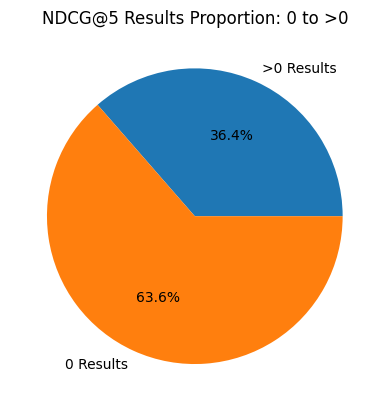

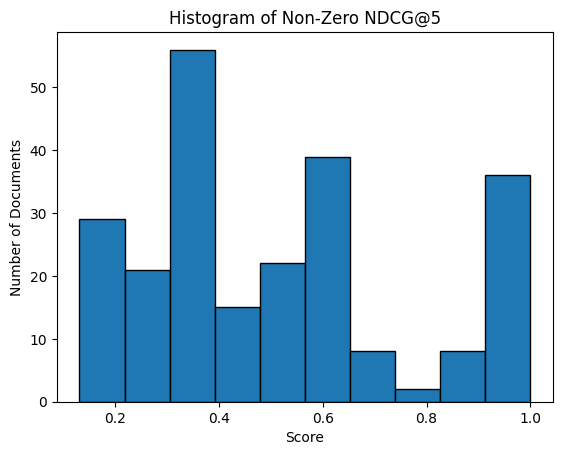

NDCG@5 Mean: 0.18988865853627918 and Std: 0.29692386698863327
NDCG@5 > 0 Mean: 0.5213891980148683 and Std: 0.2631273967008143


In [69]:
present_results(ndcgs)

In [ ]:
from haystack.dataclasses.document import Document
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore

document_store = QdrantDocumentStore(
    ":memory:",
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True,
)
document_store.write_documents([
    Document(content="This is first", embedding=[0.0]*768),  # 768-dimensional embedding
    Document(content="This is second", embedding=[0.1]*768)  # 768-dimensional embedding

])
print(document_store.count_documents())

100it [00:00, 17015.43it/s]          

2


# Póki co nie działa - do starszej wersji:

In [26]:
from haystack.nodes import EmbeddingRetriever
from haystack.document_stores import InMemoryDocumentStore

doc_store = InMemoryDocumentStore(
    similarity="cosine",  # the e5 models were trained with a cosine similarity function
    embedding_dim=768
)

e5 = EmbeddingRetriever(
    document_store=doc_store,
    embedding_model="intfloat/e5-base-v2",
    model_format="transformers",  # Make sure we specify the transformers model format
    pooling_strategy="reduce_mean",  # This is the pooling method used to train the e5 models
    top_k=20,
    max_seq_len=512,
)
doc_store.update_embeddings(e5)

ImportError: cannot import name 'PipelineSchemaError' from 'haystack.errors' (/Users/mwardynski/Documents/ds/_semestr_9/przetwarzanie_jezyka_naturalnego/labs/.venv/lib/python3.12/site-packages/haystack/errors.py)